##  Objective
To study the effect of immune infiltration in endocrine treated breast cancer patients. The data is from 36 patients who have been given Anastrazole and saples have been taken from before and after treatment. The dataset contains 15 non-responders and 24 responders.

### Import packages

In [172]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import goatools as go

### Import data
The immune signature was defined by a manual feature selection of the most co-expressed genes (ImSig), identified from the network graph. <br/>
The 'neighbour' set of genes were identified by performing a node-walk around the macrophages and T cell feature selected genes in Miru

In [2]:
# Set Working directory
WD = '//ris-fas1a.roslin.ed.ac.uk/v1anirma/Win7/Desktop/Anastrazole'
os.chdir(WD)
# Import data
exp = pd.read_csv('pre_collapse.txt', delimiter='\t', index_col=0)
sig = pd.read_csv('feature selected genes.txt', delimiter='\t', index_col=0)
response = pd.read_csv('response.txt', delimiter='\t', index_col=0)
neighbour = pd.read_csv('neighbour.txt', delimiter='\t', index_col=0)

### Reduce multiple transcripts into one gene

In [3]:
grouped = exp.groupby(exp.index).max()
grouped = grouped.apply(lambda x: np.power(x,2), axis=1)
# Write out the collapsed DataFrame if necessary
# grouped.to_csv('Post Collapse.txt', sep= "\t")

### Calculate the average expression of signature genes
The objective is to test if there is a change in the number of immune cells between the responders and non-responders. 

In [4]:
# Subset exp for sig genes
exp_sig = grouped.merge(sig, how='inner',  left_index=True, right_index=True).sort_values(['ImSig'])
# Calculate average expression of sig genes for each sample
exp_sig_mean = exp_sig.set_index('ImSig')
exp_sig_mean = exp_sig_mean.groupby(exp_sig_mean.index).mean()
# Create the DataFrame that will be used for generating the figure
exp_plot = exp_sig_mean.transpose()

Split the dataset into two parts so that the responders and non-responders can be vizualised seperately

In [5]:
exp_plot = exp_plot.join(response)
responder = exp_plot[exp_plot['response'] == "responder"]
nonresponder = exp_plot[exp_plot['response'] == "non-responder"]

In [6]:
# Melt the data for vizulalisation
exp_plot_melt_r = pd.melt(responder, id_vars=['group'], value_vars= ['B cells','Cell Cycle', 'IFN', 'Macrophages', 'T cells'])
exp_plot_melt_nr = pd.melt(nonresponder, id_vars=['group'], value_vars= ['B cells','Cell Cycle', 'IFN', 'Macrophages', 'T cells'])

### Peforming a paired-t-test

In [7]:
# Caluculating the p-value for non-responders
p_value_nr = pd.DataFrame()
nr_p = nonresponder.set_index('group').drop('response', axis=1)
for i in list(nr_p):
    cell = nr_p[[i]]
    bt = cell[cell.index == 'Before Treatment']
    at = cell[cell.index == 'After Treatment']
    bt = bt[i].tolist()
    at = at[i].tolist()
    paired_sample = stats.ttest_rel(bt, at)
    p = paired_sample.pvalue
    p ={i:[p]}
    p = pd.DataFrame(data = p).transpose()
    p_value_nr  = p_value_nr.append(p)
# Print output
p_value_nr.columns = ['Non-Responders p-value']
p_value_nr

,Non-Responders p-value
B cells,0.569306
Cell Cycle,0.000815
IFN,0.983762
Macrophages,0.365260
T cells,0.495288


In [8]:
# Caluculating the p-value for responders
p_value_r = pd.DataFrame()
r_p = responder.set_index('group').drop('response', axis=1)
for i in list(r_p):
    cell = nr_p[[i]]
    bt = cell[cell.index == 'Before Treatment']
    at = cell[cell.index == 'After Treatment']
    bt = bt[i].tolist()
    at = at[i].tolist()
    paired_sample = stats.ttest_rel(bt, at)
    p = paired_sample.pvalue
    p ={i:[p]}
    p = pd.DataFrame(data = p).transpose()
    p_value_r = p_value_r.append(p)
# Print output
p_value_r.columns = ['Responders p-value']
p_value_r

,Responders p-value
B cells,0.569306
Cell Cycle,0.000815
IFN,0.983762
Macrophages,0.365260
T cells,0.495288


### Plot the results

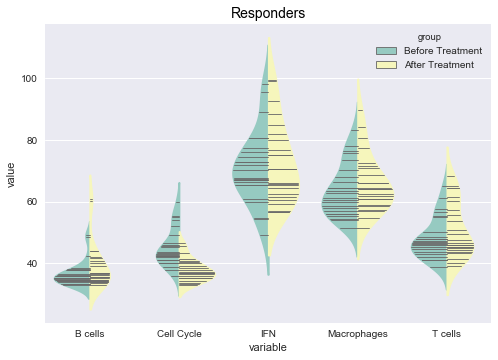

In [9]:
# Plotting Responders
g =sns.violinplot(x="variable", y="value", hue="group", split=True, inner = 'stick', data=exp_plot_melt_r, palette="Set3")
g.axes.set_title('Responders', fontsize=14, color="black")
plt.show()

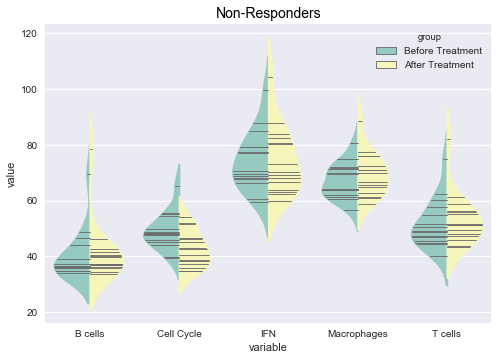

In [10]:
# Plotting Non-Responders
g =sns.violinplot(x="variable", y="value", hue="group", split=True, inner = 'stick', data=exp_plot_melt_nr, palette="Set3")
g.axes.set_title('Non-Responders', fontsize=14, color="black")
plt.show()

# Identifying the Macrophage or T cell differentiation state
It is possible that the macrophages are in two different states of activation in responders and non-responders. The following ananlysis is to identify if such a state exits.

### Function to calculate the correlation of given set of genes to a single gene

In [271]:
def genecorr(GOI):
    # Split data into before and after treatment
    data = grouped.transpose()
    data = data.join(response, how='inner')
    data_bt = data[data['group'] == 'Before Treatment']
    data_at = data[data['group'] == 'After Treatment']
    # Split the data into responders and non-responders within before and after treatment groups
    d_bt_r = data_bt[data_bt['response'] == 'responder'].drop(['response', 'group'], axis=1, inplace=False)
    d_bt_nr = data_bt[data_bt['response'] == 'non-responder'].drop(['response', 'group'], axis=1, inplace=False)
    d_at_r = data_at[data_at['response'] == 'responder'].drop(['response', 'group'], axis=1, inplace=False)
    d_at_nr = data_at[data_at['response'] == 'non-responder'].drop(['response', 'group'], axis=1, inplace=False)
    # Calculate correlation matrix
    d_bt_r_cor = d_bt_r[d_bt_r.columns[1:]].corr()[GOI][:-1]
    d_bt_nr_cor = d_bt_nr[d_bt_nr.columns[1:]].corr()[GOI][:-1]
    d_at_r_cor = d_at_r[d_at_r.columns[1:]].corr()[GOI][:-1]
    d_at_nr_cor = d_at_nr[d_at_nr.columns[1:]].corr()[GOI][:-1]
    # Create the dataframe for plotting
    # First comparision: BEFORE TREATMENT- responders vs non-responders
    bt_p = pd.concat([d_bt_r_cor, d_bt_nr_cor], axis=1, join='inner')
    bt_p.columns = range(bt_p.shape[1])
    bt_p = bt_p.join(neighbour, how = 'inner').rename(columns = {0:'Responders', 1: 'Non-Responders'})
    # Second comparision: AFTER TREATMENT- responders vs non-responders
    at_p = pd.concat([d_at_r_cor, d_at_nr_cor], axis=1, join='inner')
    at_p.columns = range(at_p.shape[1])
    at_p = at_p.join(neighbour, how = 'inner').rename(columns = {0:'Responders', 1: 'Non-Responders'})
    # Pre processing to plot the results
    # Join the two dataFrames to plot them side by side
    at_p['vars'] = ['After Treatment']*len(at_p)
    bt_p['vars'] = ['Before Treatment']*len(bt_p)
    frames = [bt_p, at_p]
    #plot = pd.concat(frames, join = 'outer')
    plot = at_p.append(bt_p)
    return plot
    return at_p
    return bt_p

# Studying changes in T cells using CD3G
The below plot shows how immune related genes are correlated with CD3G before and after treatment in responders vs non-responders. The colured area is non-significant.

In [272]:
plot = genecorr('CD3G')

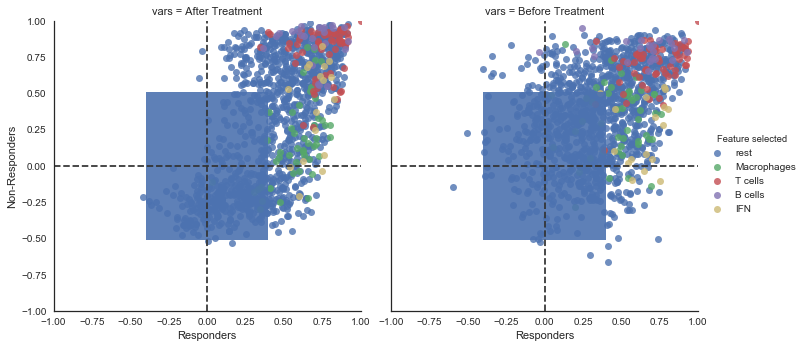

In [273]:
# sns.set(style="white", color_codes=True)
lm = sns.lmplot(data=plot, x='Responders', y='Non-Responders', col='vars', hue='Feature selected', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
    # Correlation significance areas
    #ax.axvspan(-1, -0.4, facecolor='b', alpha=0.2)
    #ax.axhspan(-1, -0.51, facecolor='b', alpha=0.2)
    x = [-0.4,0.4,0.4,-0.4]
    y = [0.51,0.51,-0.51,-0.51]
    ax.fill(x,y, facecolor='b', alpha=0.9)  
lm.set(xlim=(-1, 1), ylim=(-1, 1));
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

It can be seen from the above plot that T cell related genes are well correlated in both responders and non-responders and in both the time points. However, a change in macrophage realted genes can be observed after treatment. The macrophage related genes seem to have become less correlated in non-responders with respect to CD3. It might be interesting to perform a functional enrichment of the genes that are highly correlated in responders but are poorly (r < 0.3) or negatively correlated in non-responders.

### Isolating the highlighted set of genes

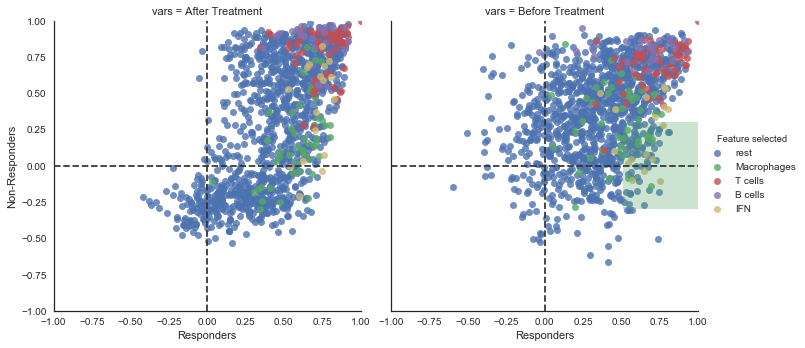

In [274]:
# sns.set(style="white", color_codes=True)
lm = sns.lmplot(data=plot, x='Responders', y='Non-Responders', col='vars', hue='Feature selected', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
x = [0.51,1,1,0.51]
y = [0.3,0.3,-.3,-.3]
plt.fill(x,y, facecolor='g', alpha=0.3)  
lm.set(xlim=(-1, 1), ylim=(-1, 1));
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

In [275]:
# Subset genes based on two conditions
set1 = at_p[(at_p['Responders'] >= 0.51)]
set1 = set1[(set1['Non-Responders'] <= 0.3)]
set1['selected genes'] = ['selected genes']*len(set1)
set1 = set1[['selected genes']]

It will be interesting to see how the highliighted genes are correlated "Before-treatment".

In [276]:
plot_1  = plot.join(set1)
plot_1  = plot_1.fillna(value= 'Rest')

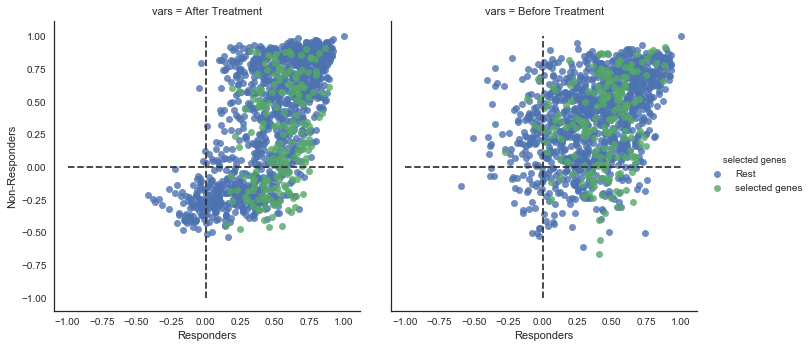

In [277]:
# sns.set(style="white", color_codes=True)
lm = sns.lmplot(data=plot_1, x='Responders', y='Non-Responders', col='vars', hue='selected genes', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

# Results for CD163
The below plot shows how immune related genes are correlated with CD3G before and after treatment in responders vs non-responders. CD68 was not available in the dataset

In [139]:
plot = genecorr('CD163')

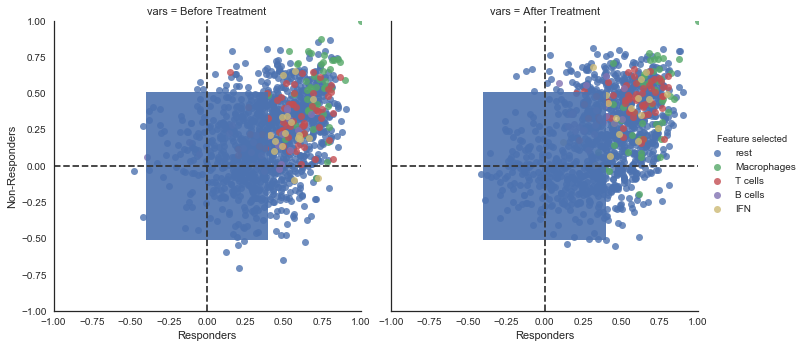

In [140]:
sns.set(style="white", color_codes=True)
lm = sns.lmplot(data=plot, x='Responders', y='Non-Responders', col='vars', hue='Feature selected', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
    x = [-0.4,0.4,0.4,-0.4]
    y = [0.51,0.51,-0.51,-0.51]
    ax.fill(x,y, facecolor='b', alpha=0.9)
lm.set(xlim=(-1, 1), ylim=(-1, 1));
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

### Enrichment analysis of interesting genes